# ***Libraries & Tools***

In [1]:
import nltk
import string
import spacy
import yake
import pytextrank
import gc
import re
import unicodedata
import concurrent.futures
import shutil
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
random.seed(42)


from pathlib import Path
from multiprocessing import Pool
from itertools import chain, groupby, product
from datetime import datetime
from enum import Enum
from typing import Callable, DefaultDict, Dict, List, Optional, Set, Tuple, Any
from collections import Counter, defaultdict
from nltk.corpus import stopwords
from tqdm.notebook import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer

/home/georgematlis/AUTH/DWS/NLP/Automatic_Keyword_Extraction_from_Documents/lib/python3.10/site-packages


In [2]:
nltk.data.path.append("/home/georgematlis/AUTH/DWS/NLP/Automatic_Keyword_Extraction_from_Documents/Downloads")

# ***Abstracts Retrieval***

In [31]:
def extract_abstracts(file_path):
    # Read the contents of the file
    with open(file_path, 'r') as file:
        abstracts = file.readlines()

   # Remove any leading or trailing whitespace characters from each line
    abstracts = [abstract.strip() for abstract in abstracts if abstract.strip()]

    # Track the number of abstracts
    num_abstracts = len(abstracts)

    return abstracts, num_abstracts

# Example usage
file_path = 'ArXiv_Citation_Graph/data.txt' 
#file_path = 'cora/data.txt'

abstracts, num_abstracts = extract_abstracts(file_path)

# Display the number of extracted abstracts
print(f'Number of extracted abstracts: {num_abstracts}')

Number of extracted abstracts: 88259


In [ ]:
abstracts

In [33]:
def clean_latex(paragraph): 

    matches = []

    # Replace common LaTeX accented characters
    latex_accents = {
        r"\\'a": "á", r"\\`a": "à", r"\\^a": "â", r'\\"a': "ä", r"\\~a": "ã", r"\\c{c}": "ç",
        r"\\'e": "é", r"\\`e": "è", r"\\^e": "ê", r'\\"e': "ë",
        r"\\'i": "í", r"\\`i": "ì", r"\\^i": "î", r'\\"i': "ï",
        r"\\'o": "ó", r"\\`o": "ò", r"\\^o": "ô", r'\\"o': "ö", r"\\~o": "õ",
        r"\\'u": "ú", r"\\`u": "ù", r"\\^u": "û", r'\\"u': "ü",
        r"\\'y": "ý", r"\\`y": "ỳ", r"\\^y": "ŷ", r'\\"y': "ÿ",
        r"\\~n": "ñ"
    }

    # Extend regex to catch instances of \^ or similar with brackets (e.g., \^{i}, \`{e})
    latex_accents.update({
        r"\\\^{a}": "â", r"\\\^{e}": "ê", r"\\\^{i}": "î", r"\\\^{o}": "ô", r"\\\^{u}": "û", r"\\\^{y}": "ŷ",
        r"\\\`{a}": "à", r"\\\`{e}": "è", r"\\\`{i}": "ì", r"\\\`{o}": "ò", r"\\\`{u}": "ù",
        r"\\'{a}": "á", r"\\'{e}": "é", r"\\'{i}": "í", r"\\'{o}": "ó", r"\\'{u}": "ú", r"\\'{y}": "ý",
        r'\\"{a}': "ä", r'\\"{e}': "ë", r'\\"{i}': "ï", r'\\"{o}': "ö", r'\\"{u}': "ü", r'\\"{y}': "ÿ",
        r"\\~{a}": "ã", r"\\~{o}": "õ", r"\\~{n}": "ñ", r"\\c{c}": "ç"
    })

    # Add other potential patterns for accented characters as needed
    latex_accents.update({
        r"\\'{A}": "Á", r"\\'{E}": "É", r"\\'{I}": "Í", r"\\'{O}": "Ó", r"\\'{U}": "Ú", r"\\'{Y}": "Ý",
        r"\\`{A}": "À", r"\\`{E}": "È", r"\\`{I}": "Ì", r"\\`{O}": "Ò", r"\\`{U}": "Ù",
        r"\\\^{A}": "Â", r"\\\^{E}": "Ê", r"\\\^{I}": "Î", r"\\\^{O}": "Ô", r"\\\^{U}": "Û", r"\\\^{Y}": "Ŷ",
        r'\\"{A}': "Ä", r'\\"{E}': "Ë", r'\\"{I}': "Ï", r'\\"{O}': "Ö", r'\\"{U}': "Ü", r'\\"{Y}': "Ÿ",
        r"\\~{A}": "Ã", r"\\~{O}": "Õ", r"\\~{N}": "Ñ", r"\\c{C}": "Ç"
    })


    for latex, char in latex_accents.items():
        paragraph = re.sub(latex, char, paragraph)

    # Remove URLs
    matches.append(len(re.findall(r'https?://(?:www\.)?\S+\.\S+|www\.\S+\.\S+', paragraph)))
    paragraph = re.sub(r'https?://(?:www\.)?\S+\.\S+|www\.\S+\.\S+', '', paragraph)

    # Remove literal dollar signs "\$"
    matches.append(len(re.findall(r'\\\$', paragraph)))
    paragraph = re.sub(r'\\\$', '', paragraph)

    # Remove block math
    matches.append(len(re.findall(r'\$\$(.*?)\$\$|\\\[(.*?)\\\]', paragraph)))
    paragraph = re.sub(r'\$\$(.*?)\$\$|\\\[(.*?)\\\]', '', paragraph, flags=re.DOTALL)

    # Replace inline math with alphabetic content
    matches.append(len(re.findall(r'\$(\b[a-zA-Z]+\b)\$', paragraph)))
    paragraph = re.sub(r'\$(\b[a-zA-Z]+\b)\$', r'\1', paragraph)  # Replace alphabetic inline math

    # Remove remaining inline math
    matches.append(len(re.findall(r'\$(.*?)\$|\\\((.*?)\\\)', paragraph)))
    paragraph = re.sub(r'\$(.*?)\$|\\\((.*?)\\\)', '', paragraph)

    # Remove nested functions
    matches.append(len(re.findall(r'[a-zA-Z_]+\((?:[^\(\){}]|\((?:[^\(\)]|\([^()]*\))*\)|\{(?:[^{}]|\{[^{}]*\})*\})*\)', paragraph)))
    paragraph = re.sub(r'[a-zA-Z_]+\((?:[^\(\){}]|\((?:[^\(\)]|\([^()]*\))*\)|\{(?:[^{}]|\{[^{}]*\})*\})*\)', '', paragraph)

    # Remove \begin{...} and \end{...} commands
    matches.append(len(re.findall(r'\\begin\{[a-zA-Z]+\}|\\end\{[a-zA-Z]+\}', paragraph)))
    paragraph = re.sub(r'\\begin\{[a-zA-Z]+\}|\\end\{[a-zA-Z]+\}', '', paragraph, flags=re.DOTALL)

    # Replace standalone LaTeX commands
    matches.append(len(re.findall(r"\\[a-zA-Z]+\{(.*?)\}", paragraph)))
    paragraph = re.sub(r"\\[a-zA-Z]+\{(.*?)\}", r"\1", paragraph)

    # Remove remaining LaTeX commands and escape sequences
    matches.append(len(re.findall(r'\\[a-zA-Z]+(\{.*?\}|\[.*?\])?', paragraph)))
    paragraph = re.sub(r'\\[a-zA-Z]+(\{.*?\}|\[.*?\])?', '', paragraph)

    # Remove extraneous braces and brackets
    matches.append(len(re.findall(r'[{}\\~\[\]]', paragraph)))
    paragraph = re.sub(r'[{}\\~\[\]]', '', paragraph)

    # Fix misplaced whitespace before commas and periods
    matches.append(len(re.findall(r'\s+([,\.])', paragraph)))
    paragraph = re.sub(r'\s+([,\.])', r'\1', paragraph)

    # Clean up extra whitespace
    paragraph = ' '.join(paragraph.split())

    # Replace multiple commas with a single comma
    matches.append(len(re.findall(r',+', paragraph)))
    paragraph = re.sub(r',+', ',', paragraph)

    # Replace multiple periods with a single period
    matches.append(len(re.findall(r'\.+', paragraph)))
    paragraph = re.sub(r'\.+', '.', paragraph)

    # Normalize Unicode to ensure proper representation of accents
    paragraph = unicodedata.normalize("NFC", paragraph)

    return paragraph, matches

In [34]:
abstract_re_matches = []
clean_abstracts = []
for i in range(len(abstracts)):
    clean_abstract, matches = clean_latex(abstracts[i])
    clean_abstracts.append(clean_abstract)
    abstract_re_matches.append(matches)

abstract_re_matches_sum = [sum(row[i] for row in abstract_re_matches) for i in range(len(abstract_re_matches[0]))]

In [35]:
abstract_re_matches_sum

[1712,
 22,
 261,
 34363,
 66764,
 7730,
 38,
 6416,
 5974,
 25540,
 21067,
 618795,
 734214]

In [36]:
abstract_re_matches_sum = {
    'Remove URLs'                                           : abstract_re_matches_sum[0],
    'Remove literal dollar signs \$'                        : abstract_re_matches_sum[1],
    'Remove block math'                                     : abstract_re_matches_sum[2],
    'Replace inline math with alphabetic content'           : abstract_re_matches_sum[3],
    'Remove remaining inline math'                          : abstract_re_matches_sum[4],
    'Remove nested functions'                               : abstract_re_matches_sum[5],
    'Remove \begin{...} and \end{...} commands'             : abstract_re_matches_sum[6],
    'Replace standalone LaTeX commands'                     : abstract_re_matches_sum[7],
    'Remove remaining LaTeX commands and escape sequences'  : abstract_re_matches_sum[8],
    'Remove extraneous braces and brackets'                 : abstract_re_matches_sum[9],
    'Fix misplaced whitespace before commas and periods'    : abstract_re_matches_sum[10],
    'Replace multiple commas with a single comma'           : abstract_re_matches_sum[11],
    'Replace multiple periods with a single period'         : abstract_re_matches_sum[12]
}

In [37]:
abstract_re_matches_sum

{'Remove URLs': 1712,
 'Remove literal dollar signs \\$': 22,
 'Remove block math': 261,
 'Replace inline math with alphabetic content': 34363,
 'Remove remaining inline math': 66764,
 'Remove nested functions': 7730,
 'Remove \x08egin{...} and \\end{...} commands': 38,
 'Replace standalone LaTeX commands': 6416,
 'Remove remaining LaTeX commands and escape sequences': 5974,
 'Remove extraneous braces and brackets': 25540,
 'Fix misplaced whitespace before commas and periods': 21067,
 'Replace multiple commas with a single comma': 618795,
 'Replace multiple periods with a single period': 734214}

In [38]:
abstracts = clean_abstracts

In [39]:
with open('ArXiv_Citation_Graph/clean_data.txt', 'w') as file:
    for abstract in abstracts:
        file.write(f"{abstract}\n")

In [5]:
def prepareData(datasetName, ratio, batch_size):
  f = open('%s/graph.txt' % datasetName, 'rb')
  edges = [i for i in f]
  selected = int(len(edges) * float(ratio))
  selected = selected - selected % batch_size
  selected = random.sample(edges, selected)
  selected_set = set(selected)
  remain = [i for i in edges if i not in selected_set]
  
  try:
    temp_dir = Path(f'{datasetName}/temp')

    # Check if the directory exists, if so, delete it
    if temp_dir.exists() and temp_dir.is_dir():
        #shutil.rmtree(temp_dir)
        #print("Existing directory deleted.")
        pass
    else:
        # Create the directory
        temp_dir.mkdir(parents=True, exist_ok=True)
        print("Directory created successfully.")

  except Exception as e:
      print(f"An error occurred: {e}")

  fw1 = open(f"{datasetName}/temp/sgraph{str(ratio).split('.')[1]}.txt", 'wb')
  fw2 = open(f"{datasetName}/temp/tgraph{str(1.0 - ratio).split('.')[1]}.txt", 'wb')

  for i in selected:
      fw1.write(i)
  for i in remain:
      fw2.write(i)

In [22]:
prepareData("ArXiv_CS_Papers_Citation_Network", 0.75, 64)

Filtering edges: 100%|██████████| 470994/470994 [00:00<00:00, 1124917.94it/s]


In [3]:
def filter_abstracts_by_edges(edge_file, abstracts):
    unique_nodes = set()

    # Read the edge file and collect unique node IDs
    with open(edge_file, 'r') as file:
        for line in file:
            # Split on whitespace (handles both tabs and spaces)
            node1, node2 = line.strip().split()
            unique_nodes.add(int(node1))
            unique_nodes.add(int(node2))

    # Create a new list of abstracts for the unique nodes
    filtered_abstracts = [abstracts[node] for node in unique_nodes if node < len(abstracts)]

    return filtered_abstracts

In [8]:
filtered_abstracts = filter_abstracts_by_edges("ArXiv_CS_Papers_Citation_Network/temp/sgraph75.txt", abstracts)

In [9]:
len(filtered_abstracts)

86326

In [6]:
abstracts = filtered_abstracts

In [7]:
num_abstracts = len(abstracts)

# ***Keyword Extraction***

## RAKE

In [22]:
# Readability type definitions.
Word = str
Sentence = str
Phrase = Tuple[str, ...]

In [23]:
class Metric(Enum):
    """Different metrics that can be used for ranking."""

    DEGREE_TO_FREQUENCY_RATIO = 0  # Uses d(w)/f(w) as the metric
    WORD_DEGREE = 1  # Uses d(w) alone as the metric
    WORD_FREQUENCY = 2  # Uses f(w) alone as the metric

In [24]:
class Rake:
    """Rapid Automatic Keyword Extraction Algorithm."""

    def __init__(
        self,
        stopwords: Optional[Set[str]] = None,
        punctuations: Optional[Set[str]] = None,
        language: str = 'english',
        ranking_metric: Metric = Metric.DEGREE_TO_FREQUENCY_RATIO,
        max_length: int = 100000,
        min_length: int = 1,
        include_repeated_phrases: bool = True,
        sentence_tokenizer: Optional[Callable[[str], List[str]]] = None,
        word_tokenizer: Optional[Callable[[str], List[str]]] = None
    ):
        """Constructor.

        :param stopwords: Words to be ignored for keyword extraction.
        :param punctuations: Punctuations to be ignored for keyword extraction.
        :param language: Language to be used for stopwords.
        :param max_length: Maximum limit on the number of words in a phrase
                           (Inclusive. Defaults to 100000)
        :param min_length: Minimum limit on the number of words in a phrase
                           (Inclusive. Defaults to 1)
        :param include_repeated_phrases: If phrases repeat in phrase list consider
                            them as is without dropping any phrases for future
                            calculations. (Defaults to True) Ex: "Magic systems is
                            a company. Magic systems was founded by Raul".

                            If repeated phrases are allowed phrase list would be
                            [
                                (magic, systems), (company,), (magic, systems),
                                (founded,), (raul,)
                            ]

                            If they aren't allowed phrase list would be
                            [
                                (magic, systems), (company,),
                                (founded,), (raul,)
                            ]
        :param sentence_tokenizer: Tokenizer used to tokenize the text string into sentences.
        :param word_tokenizer: Tokenizer used to tokenize the sentence string into words.
        """

        # By default use degree to frequency ratio as the metric.
        if isinstance(ranking_metric, Metric):
            self.metric = ranking_metric
        else:
            self.metric = Metric.DEGREE_TO_FREQUENCY_RATIO

        # If stopwords not provided we use language stopwords by default.
        self.stopwords: Set[str]
        if stopwords:
            self.stopwords = stopwords
        else:
            self.stopwords = set(nltk.corpus.stopwords.words(language))

        # If punctuations are not provided we ignore all punctuation symbols.
        self.punctuations: Set[str]
        if punctuations:
            self.punctuations = punctuations
        else:
            self.punctuations = set(string.punctuation)

        # All things which act as sentence breaks during keyword extraction.
        self.to_ignore: Set[str] = set(chain(self.stopwords, self.punctuations))

        # Assign min or max length to the attributes
        self.min_length: int = min_length
        self.max_length: int = max_length

        # Whether we should include repeated phreases in the computation or not.
        self.include_repeated_phrases: bool = include_repeated_phrases

        # Tokenizers.
        self.sentence_tokenizer: Callable[[str], List[str]]
        if sentence_tokenizer:
            self.sentence_tokenizer = sentence_tokenizer
        else:
            self.sentence_tokenizer = nltk.tokenize.sent_tokenize

        self.word_tokenizer: Callable[[str], List[str]]
        if word_tokenizer:
            self.word_tokenizer = word_tokenizer
        else:
            self.word_tokenizer = nltk.tokenize.wordpunct_tokenize

        # Stuff to be extracted from the provided text.
        self.frequency_dist: Dict[Word, int]
        self.degree: Dict[Word, int]
        self.rank_list: List[Tuple[float, Sentence]]
        self.ranked_phrases: List[Sentence]

    def extract_keywords_from_text(self, text: str):
        """Method to extract keywords from the text provided.

        :param text: Text to extract keywords from, provided as a string.
        """
        sentences: List[Sentence] = self._tokenize_text_to_sentences(text)
        self.extract_keywords_from_sentences(sentences)


    def extract_keywords_from_sentences(self, sentences: List[Sentence]):
        """Method to extract keywords from the list of sentences provided.

        :param sentences: Text to extraxt keywords from, provided as a list
                          of strings, where each string is a sentence.
        """
        phrase_list: List[Phrase] = self._generate_phrases(sentences)
        self._build_frequency_dist(phrase_list)
        self._build_word_co_occurance_graph(phrase_list)
        self._build_ranklist(phrase_list)


    def get_ranked_phrases(self) -> List[Sentence]:
        """Method to fetch ranked keyword strings.

        :return: List of strings where each string represents an extracted
                 keyword string.
        """
        return self.ranked_phrases


    def get_ranked_phrases_with_scores(self) -> List[Tuple[float, Sentence]]:
        """Method to fetch ranked keyword strings along with their scores.

        :return: List of tuples where each tuple is formed of an extracted
                 keyword string and its score. Ex: (5.68, 'Four Scoures')
        """
        return self.rank_list


    def get_word_frequency_distribution(self) -> Dict[Word, int]:
        """Method to fetch the word frequency distribution in the given text.

        :return: Dictionary (defaultdict) of the format `word -> frequency`.
        """
        return self.frequency_dist


    def get_word_degrees(self) -> Dict[Word, int]:
        """Method to fetch the degree of words in the given text. Degree can be
        defined as sum of co-occurances of the word with other words in the
        given text.

        :return: Dictionary (defaultdict) of the format `word -> degree`.
        """
        return self.degree


    def _tokenize_text_to_sentences(self, text: str) -> List[Sentence]:
        """Tokenizes the given text string into sentences using the configured
        sentence tokenizer. Configuration uses `nltk.tokenize.sent_tokenize`
        by default.

        :param text: String text to tokenize into sentences.
        :return: List of sentences as per the tokenizer used.
        """
        return self.sentence_tokenizer(text)

    def _tokenize_sentence_to_words(self, sentence: Sentence) -> List[Word]:
        """Tokenizes the given sentence string into words using the configured
        word tokenizer. Configuration uses `nltk.tokenize.wordpunct_tokenize`
        by default.

        :param sentence: String sentence to tokenize into words.
        :return: List of words as per the tokenizer used.
        """
        return self.word_tokenizer(sentence)

    def _build_frequency_dist(self, phrase_list: List[Phrase]) -> None:
        """Builds frequency distribution of the words in the given body of text.

        :param phrase_list: List of List of strings where each sublist is a
                            collection of words which form a contender phrase.
        """
        self.frequency_dist = Counter(chain.from_iterable(phrase_list))

    def _build_word_co_occurance_graph(self, phrase_list: List[Phrase]) -> None:
        """Builds the co-occurance graph of words in the given body of text to
        compute degree of each word.

        :param phrase_list: List of List of strings where each sublist is a
                            collection of words which form a contender phrase.
        """
        co_occurance_graph: DefaultDict[Word, DefaultDict[Word, int]] = defaultdict(lambda: defaultdict(lambda: 0))
        for phrase in phrase_list:
            # For each phrase in the phrase list, count co-occurances of the
            # word with other words in the phrase.
            #
            # Note: Keep the co-occurances graph as is, to help facilitate its
            # use in other creative ways if required later.
            for (word, coword) in product(phrase, phrase):
                co_occurance_graph[word][coword] += 1

        # Print the co-occurance_graph
        """
        for word, co_words in co_occurance_graph.items():
            print(f"{word}:")
            for co_word, count in co_words.items():
                print(f"  {co_word}: {count}")
            print("=" * 30)
        """
        self.degree = defaultdict(lambda: 0)
        for key in co_occurance_graph:
            self.degree[key] = sum(co_occurance_graph[key].values())
    

    def _build_ranklist(self, phrase_list: List[Phrase]):
        """Method to rank each contender phrase using the formula

              phrase_score = sum of scores of words in the phrase.
              word_score = d(w) or f(w) or d(w)/f(w) where d is degree
                           and f is frequency.

        :param phrase_list: List of List of strings where each sublist is a
                            collection of words which form a contender phrase.
        """

        self.rank_list = []
        for phrase in phrase_list:
            rank = 0.0
            for word in phrase:
                if self.metric == Metric.DEGREE_TO_FREQUENCY_RATIO:
                    rank += 1.0 * self.degree[word] / self.frequency_dist[word]
                elif self.metric == Metric.WORD_DEGREE:
                    rank += 1.0 * self.degree[word]
                else:
                    rank += 1.0 * self.frequency_dist[word]
            self.rank_list.append((rank, ' '.join(phrase)))
        self.rank_list.sort(reverse=True)
        self.ranked_phrases = [ph[1] for ph in self.rank_list]
        

    # ==========================================================================
    def _generate_phrases(self, sentences: List[Sentence]) -> List[Phrase]:
        """Method to generate contender phrases given the sentences of the text
        document.

        :param sentences: List of strings where each string represents a
                          sentence which forms the text.
        :return: Set of string tuples where each tuple is a collection
                 of words forming a contender phrase.
        """
        phrase_list: List[Phrase] = []
        # Create contender phrases from sentences.
        for sentence in sentences:
            word_list: List[Word] = [word.lower() for word in self._tokenize_sentence_to_words(sentence)]
            phrase_list.extend(self._get_phrase_list_from_words(word_list))

        # Based on user's choice to include or not include repeated phrases
        # we compute the phrase list and return it. If not including repeated
        # phrases, we only include the first occurance of the phrase and drop
        # the rest.
        if not self.include_repeated_phrases:
            unique_phrase_tracker: Set[Phrase] = set()
            non_repeated_phrase_list: List[Phrase] = []
            for phrase in phrase_list:
                if phrase not in unique_phrase_tracker:
                    unique_phrase_tracker.add(phrase)
                    non_repeated_phrase_list.append(phrase)
            return non_repeated_phrase_list

        return phrase_list

    def _get_phrase_list_from_words(self, word_list: List[Word]) -> List[Phrase]:
        """Method to create contender phrases from the list of words that form
        a sentence by dropping stopwords and punctuations and grouping the left
        words into phrases. Only phrases in the given length range (both limits
        inclusive) would be considered to build co-occurrence matrix. Ex:

        Sentence: Red apples, are good in flavour.
        List of words: ['red', 'apples', ",", 'are', 'good', 'in', 'flavour']
        List after dropping punctuations and stopwords.
        List of words: ['red', 'apples', *, *, good, *, 'flavour']
        List of phrases: [('red', 'apples'), ('good',), ('flavour',)]

        List of phrases with a correct length:
        For the range [1, 2]: [('red', 'apples'), ('good',), ('flavour',)]
        For the range [1, 1]: [('good',), ('flavour',)]
        For the range [2, 2]: [('red', 'apples')]

        :param word_list: List of words which form a sentence when joined in
                          the same order.
        :return: List of contender phrases honouring phrase length requirements
                 that are formed after dropping stopwords and punctuations.
        """
        groups = groupby(word_list, lambda x: x not in self.to_ignore)
        phrases: List[Phrase] = [tuple(group[1]) for group in groups if group[0]]
        return list(filter(lambda x: self.min_length <= len(x) <= self.max_length, phrases))

## TF-IDF Functions

In [24]:
"""
Use this function when there are few abstracts (few abstracts means small number of words).
"""

def extract_keywords_tfidf(abstracts, T):
    # Initialize TF-IDF vectorizer
    vectorizer = TfidfVectorizer()
    tfidf_matrix = vectorizer.fit_transform(abstracts)

    # Get feature names (i.e., words)
    feature_names = vectorizer.get_feature_names_out()

    # Convert the TF-IDF matrix to a DataFrame
    tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)

    # Extract top_n keywords for each abstract
    keywords_per_abstract = []
    for idx, row in tfidf_df.iterrows():
        # Get the top_n words with highest TF-IDF scores
        top_keywords = row.nlargest(T).index.tolist()
        keywords_per_abstract.append(top_keywords)

    return keywords_per_abstract

In [ ]:
"""
Use this function when the number of abstracts is large and dividing with a number results in an integer. 
"""

def extract_keywords_tfidf(abstracts, T, batch_size):
    # Fit once on the entire data to get document frequencies (IDF values)
    vectorizer = TfidfVectorizer()
    vectorizer.fit(abstracts)  # Only fit to get IDF and vocabulary

     # Get feature names (i.e., words)
    feature_names = vectorizer.get_feature_names_out()

    keywords_per_abstract = []
    for i in range(0, len(abstracts), batch_size):

      batch_abstracts = abstracts[i:i + batch_size]
      tfidf_matrix = vectorizer.transform(batch_abstracts)  # Use transform, not fit_transform

      # Now, proceed with extracting top keywords as before
      for row in tfidf_matrix:
          row_array = row.toarray().flatten()
          top_keywords = [feature_names[j] for j in row_array.argsort()[-T:][::-1]]
          keywords_per_abstract.append(top_keywords)

    return keywords_per_abstract

In [25]:
"""
Use this function when the number of abstracts is large and dividing results always in a float number.
"""


def extract_keywords_tfidf(abstracts, T, ranges):
    # Fit once on the entire data to get document frequencies (IDF values)
    vectorizer = TfidfVectorizer()
    vectorizer.fit(abstracts)  # Only fit to get IDF and vocabulary

     # Get feature names (i.e., words)
    feature_names = vectorizer.get_feature_names_out()

    keywords_per_abstract = []
    for start, end in ranges:
        batch_abstracts = abstracts[start:end]  # Extract batch abstracts
        tfidf_matrix = vectorizer.transform(batch_abstracts)  # Use transform

        # Process each row in the batch
        for row in tfidf_matrix:
            row_array = row.toarray().flatten()
            top_keywords = [feature_names[j] for j in row_array.argsort()[-T:][::-1]]
            keywords_per_abstract.append(top_keywords)
    
    gc.collect()
    return keywords_per_abstract

### TF-IDF Parallel Functions

In [12]:
def process_tfidf_batch(batch_abstracts, vectorizer, feature_names, T, batch_index):
    """
    Process a batch of abstracts and extract the top keywords.
    """
    tfidf_matrix = vectorizer.transform(batch_abstracts)  # Use transform
    batch_keywords = []

    # Process each row in the batch
    for row in tfidf_matrix:
        row_array = row.toarray().flatten()
        top_keywords = [feature_names[j] for j in row_array.argsort()[-T:][::-1]]
        batch_keywords.append(top_keywords)
    
    return batch_index, batch_keywords

def parallel_tfidf_processing(abstracts, ranges, T, num_threads=5):

    start_time = datetime.now()

    # Fit once on the entire data to get document frequencies (IDF values)
    vectorizer = TfidfVectorizer()
    vectorizer.fit(abstracts)  # Only fit to get IDF and vocabulary

    # Get feature names (i.e., words)
    feature_names = vectorizer.get_feature_names_out()

    keywords_per_abstract = [None] * len(abstracts) 
    
    with concurrent.futures.ProcessPoolExecutor(max_workers=num_threads) as executor:
        # Submit tasks to the thread pool for each range of abstracts
        futures = [
            executor.submit(process_tfidf_batch, abstracts[start:end], vectorizer, feature_names, T, batch_index)
            for batch_index, (start, end) in enumerate(ranges)
        ]
        
        # Wait for the results and place them in the correct position in the final list
        for future in concurrent.futures.as_completed(futures):
            batch_index, batch_keywords = future.result()
            start, end = ranges[batch_index]
            keywords_per_abstract[start:end] = batch_keywords  # Place results in the correct range

        end_time = datetime.now()
        print(f'TF-IDF time: {(end_time - start_time).total_seconds()}')

    gc.collect()

    
    return keywords_per_abstract

## Keyword & Keyphrase Methods

In [27]:
def save_keywords_to_files(lists_of_keywords, file_names):
    for keywords_list, file_name in zip(lists_of_keywords, file_names):
        with open(file_name, 'w') as file:
            for keywords in keywords_list:
                line = ' '.join(keywords)
                file.write(line + '\n')
    
    gc.collect()

In [28]:
def process_keywords(keywords, output_file):
    word_counts = []  # To store word count per sublist
    total_word_count = 0
    total_non_word_count = 0

    for sublist in keywords:
        sublist_word_count = 0  # Count words in this sublist
        sublist_non_word_count = 0

        for keyphrase in sublist:
            # Split on whitespace or dash but preserve valid words
            words = [word for part in keyphrase.split('-') for word in part.split()]
            
            for word in words:
                if word.isalpha():  # Check if it's a valid word
                    sublist_word_count += 1
                    total_word_count += 1
                else:
                    sublist_non_word_count += 1
                    total_non_word_count += 1

        word_counts.append(sublist_word_count)

    gc.collect()
    
    # Save word counts to the output file
    with open(output_file, 'w') as f:
        for count in word_counts:
            f.write(str(count) + '\n')

    return total_word_count, total_non_word_count

In [26]:
T = [5,10]

In [29]:
batch_size = int(num_abstracts / 5)
print(batch_size)

17651


In [30]:
ranges = []
start = 0
while start < num_abstracts:
    end = min(start + batch_size, num_abstracts)  # Ensure the last range includes all remaining abstracts
    ranges.append([start, end])
    start = end


ranges[-2][1] = ranges[-1][1]
del ranges[-1]

# Print ranges for verification
print(f"Created {len(ranges)} ranges:")
for r in ranges:
    print(r)

Created 5 ranges:
[0, 17651]
[17651, 35302]
[35302, 52953]
[52953, 70604]
[70604, 88259]


### TF-IDF

In [17]:
# Preprocess the abstracts: remove punctuation and stopwords
stop_words = set(stopwords.words('english'))
punctuation = set(string.punctuation)

In [18]:
def preprocess(text):
  text = text.lower()  # Lowercase
  text = ''.join([ch for ch in text if ch not in punctuation])  # Remove punctuation
  tokens = text.split()
  tokens = [word for word in tokens if word not in stop_words]  # Remove stopwords
  return ' '.join(tokens)

In [19]:
# Preprocess each abstract
preprocessed_abstracts = [preprocess(abstract) for abstract in abstracts]

In [24]:
tfidf_keywords = parallel_tfidf_processing(preprocessed_abstracts, ranges, T)

TF-IDF time: 77.888564


In [23]:
"""
Run this cell if you want to execute the TF-IDF function in serial
"""

start_time = datetime.now()
tfidf_keywords = extract_keywords_tfidf(preprocessed_abstracts, T, ranges)
#tfidf_keywords = extract_keywords_tfidf(preprocessed_abstracts, T)
end_time = datetime.now()

print(f'TF-IDF time: {(end_time - start_time).total_seconds()}')

TF-IDF time: 237.563014


In [33]:
tfidf_total_word_count, tfidf_total_non_word_count = process_keywords(tfidf_keywords, "Word_Counts/TFIDF10.txt")

In [34]:
tfidf_total_non_word_count / tfidf_total_word_count

0.023038921357483477

In [ ]:
len(tfidf_keywords)

In [15]:
tfidf_keywords[:5]

[['convex', 'heuristic', 'megaprior', 'sequence', 'discovering'],
 ['cure', 'colposuspension', 'rate', 'risk', 'medical'],
 ['channel', 'calls', 'cell', 'call', 'service'],
 ['pomdps', 'mdps', 'observable', 'partially', 'finding'],
 ['variational', 'graphical', 'approximations', 'models', 'bounds']]

### Other Methods

#### Keyword Extraction Methods in Parallel

In [19]:
# Function to process a batch of abstracts
def process_batch(batch_abstracts, T, batch_index, kextraction_method):
    batch_keywords = []
    
    for abstract in batch_abstracts:

        # === RAKE ===
        
        """ oR = Rake(ranking_metric=Metric.DEGREE_TO_FREQUENCY_RATIO)
        oR.extract_keywords_from_text(abstract)
        unique_ranked_keywords = sorted(list(set(oR.get_ranked_phrases_with_scores())), key=lambda x: x[0], reverse=True)[:T]
        batch_keywords.append([keyphrase for _, keyphrase in unique_ranked_keywords]) """
        
        
        # === YAKE ===
        
        """ yake_res = sorted(kextraction_method.extract_keywords(abstract), key=lambda x: x[1], reverse=True)
        batch_keywords.append([keyphrase for keyphrase, _ in yake_res]) """
        

        # === Rank Extraction Methods ===
        
        rank_res = kextraction_method(abstract)
        batch_keywords.append([keyphrase.text for keyphrase in rank_res._.phrases[:T]])
        
    return batch_index, batch_keywords

def process_batch_rake(batch_abstracts, T, batch_index):
    batch_keywords = []
    
    for abstract in batch_abstracts:        
        oR = Rake(ranking_metric=Metric.DEGREE_TO_FREQUENCY_RATIO)
        oR.extract_keywords_from_text(abstract)
        unique_ranked_keywords = sorted(list(set(oR.get_ranked_phrases_with_scores())), key=lambda x: x[0], reverse=True)[:T]
        batch_keywords.append([keyphrase for _, keyphrase in unique_ranked_keywords])

    return batch_index, batch_keywords

def process_batch_yake(batch_abstracts, T, batch_index, kextraction_method):
    batch_keywords = []
    
    for abstract in batch_abstracts:        
        yake_res = sorted(kextraction_method.extract_keywords(abstract), key=lambda x: x[1], reverse=True)
        batch_keywords.append([keyphrase for keyphrase, _ in yake_res])

    return batch_index, batch_keywords

def process_batch_rank(batch_abstracts, T, batch_index, kextraction_method):
    batch_keywords = []
    
    for abstract in batch_abstracts:        
        rank_res = kextraction_method(abstract)
        batch_keywords.append([keyphrase.text for keyphrase in rank_res._.phrases[:T]])

    return batch_index, batch_keywords

# Parallel processing function
def parallel_kextraction_processing(abstracts, ranges, T, kextraction_method, num_threads=5, kextraction_method_obj=None):
    keywords = [None] * len(abstracts)  # Initialize the final list

    kextraction_function = None
    if kextraction_method == "RAKE":
        kextraction_function = process_batch_rake
    elif kextraction_method == "YAKE":
        kextraction_function = process_batch_yake
    else:
        kextraction_function = process_batch_rank


    start_time = datetime.now()
    
    with concurrent.futures.ProcessPoolExecutor(max_workers=num_threads) as executor:
        futures = [
            executor.submit(kextraction_function, abstracts[start:end], T, batch_index, kextraction_method_obj)
            for batch_index, (start, end) in enumerate(ranges)
        ]
        
        for future in concurrent.futures.as_completed(futures):
            batch_index, batch_keywords = future.result()
            start, end = ranges[batch_index]
            keywords[start:end] = batch_keywords  # Place results in the correct range

        end_time = datetime.now()
        print(f'Time {kextraction_method}: {((end_time - start_time).total_seconds()) / 60.0}')

    gc.collect()
    return keywords

##### Execute all extraction methods in parallel

In [ ]:
keywords = {
    'RAKE5': None,
    'YAKE5': None,
    'TFIDF5': None,
    'TextRank5': None,
    'PositionRank5': None,
    'TopicRank5': None,

    'RAKE10': None,
    'YAKE10': None,
    'TFIDF10': None,
    'TextRank10': None,
    'PositionRank10': None,
    'TopicRank10': None
}


for t in T:

    keywords[f'TFIDF{t}'] = parallel_tfidf_processing(preprocessed_abstracts, ranges, t)
    keywords[f'RAKE{t}'] = parallel_kextraction_processing(abstracts, ranges, t, 'RAKE')

    yake_custom_keyword_extractor = yake.KeywordExtractor(lan='en', n=3, dedupLim=0.9, dedupFunc='seqm', windowsSize=1, top=t, features=None)
    keywords[f'YAKE{t}'] = parallel_kextraction_processing(abstracts, ranges, t, 'YAKE', kextraction_method_obj=yake_custom_keyword_extractor)
    del yake_custom_keyword_extractor
    gc.collect()

    
    topicrank = spacy.load("en_core_web_lg-3.7.1-py3-none-any/en_core_web_lg/en_core_web_lg-3.7.1")
    topicrank.add_pipe("topicrank")
    keywords[f'TopicRank{t}'] = parallel_kextraction_processing(abstracts, ranges, t, 'Topic Rank', kextraction_method_obj=topicrank)
    del topicrank
    gc.collect()

    textrank = spacy.load("en_core_web_lg-3.7.1-py3-none-any/en_core_web_lg/en_core_web_lg-3.7.1")
    textrank.add_pipe("textrank")
    keywords[f'TextRank{t}'] = parallel_kextraction_processing(abstracts, ranges, t, 'Text Rank', kextraction_method_obj=textrank)
    del textrank
    gc.collect()

    positionrank = spacy.load("en_core_web_lg-3.7.1-py3-none-any/en_core_web_lg/en_core_web_lg-3.7.1")
    positionrank.add_pipe("positionrank")
    keywords[f'PositionRank{t}'] = parallel_kextraction_processing(abstracts, ranges, t, 'Position Rank', kextraction_method_obj=positionrank)
    del positionrank
    gc.collect()



##### Execute one extraction method at a time

In [ ]:
topicrank = spacy.load("en_core_web_lg-3.7.1-py3-none-any/en_core_web_lg/en_core_web_lg-3.7.1")
positionrank = spacy.load("en_core_web_lg-3.7.1-py3-none-any/en_core_web_lg/en_core_web_lg-3.7.1")
textrank = spacy.load("en_core_web_lg-3.7.1-py3-none-any/en_core_web_lg/en_core_web_lg-3.7.1")

textrank.add_pipe("textrank")
positionrank.add_pipe("positionrank")
topicrank.add_pipe("topicrank")

In [38]:
#oR = Rake(ranking_metric=Metric.DEGREE_TO_FREQUENCY_RATIO)
yake_custom_keyword_extractor = yake.KeywordExtractor(lan='en', n=3, dedupLim=0.9, dedupFunc='seqm', windowsSize=1, top=T, features=None)

In [20]:
keywords = parallel_kextraction_processing(abstracts, ranges, T, positionrank)

Time: 655.299087


In [15]:
total_word_count, total_non_word_count = process_keywords(keywords, "Word_Counts/PYAKE5.txt")
print(total_non_word_count / total_word_count)

In [ ]:
keywords[:5]

In [21]:
# Initialize counters
total_keywords = 0
total_duplicates = 0

# Process each sublist
for sublist in keywords:
    # Count total keywords in the sublist
    total_keywords += len(sublist)
    
    # Count duplicates in the sublist
    unique_keywords = set(sublist)
    duplicates = len(sublist) - len(unique_keywords)
    total_duplicates += duplicates

# Print results
print(f"Total number of keywords: {total_keywords}")
print(f"Total number of duplicates: {total_duplicates}")

Total number of keywords: 441295
Total number of duplicates: 0


#### Keyword Extraction Methods in Serial

##### Execute all extraction methods

In [ ]:
KE_methods = ['TFIDF', 'RAKE', 'YAKE', 'PosR', 'TextR', 'TopicR']

for epoch in range(6):

    if KE_methods[epoch] == 'TFIDF':

        for t in T:
            start_time = datetime.now()
            tfidf_keywords = extract_keywords_tfidf(preprocessed_abstracts, t, ranges)
            end_time = datetime.now()

            print(f'TF-IDF {t} Time: {((end_time - start_time).total_seconds()) / 60.0}')
            tfidf_total_word_count, tfidf_total_non_word_count = process_keywords(tfidf_keywords, f'ArXiv_Citation_Graph/Word_Counts/TFIDF{t}.txt')
            print(f'% of Non-Words: {tfidf_total_non_word_count / tfidf_total_word_count}')
            save_keywords_to_files(tfidf_keywords, f'ArXiv_Citation_Graph/TFIDF{t}.txt')
            gc.collect()

    elif KE_methods[epoch] == 'RAKE':

        for t in T:
            oRake_keywords = []
            start_time = datetime.now()
            for i in range(len(abstracts)):

                oR = Rake(ranking_metric=Metric.DEGREE_TO_FREQUENCY_RATIO)
                oR.extract_keywords_from_text(abstracts[i])
                unique_ranked_keywords = sorted(list(set(oR.get_ranked_phrases_with_scores())), key=lambda x: x[0], reverse=True)[:t]
                oRake_keywords.append([keyphrase for _, keyphrase in unique_ranked_keywords])

            end_time = datetime.now()
            print(f'RAKE {t} Time: {((end_time - start_time).total_seconds()) / 60.0}')
            total_word_count, total_non_word_count = process_keywords(oRake_keywords, f'ArXiv_Citation_Graph/Word_Counts/RAKE{t}.txt')
            print(f'% of Non-Words: {total_non_word_count / total_word_count}')
            save_keywords_to_files(oRake_keywords, f'ArXiv_Citation_Graph/RAKE{t}.txt')
            gc.collect()

    elif KE_methods[epoch] == 'YAKE':
        
        for t in T:
            yake_custom_keyword_extractor = yake.KeywordExtractor(lan='en', n=3, dedupLim=0.9, dedupFunc='seqm', windowsSize=1, top=t, features=None)
            yake_keywords = []

            start_time = datetime.now()
            for i in range(len(abstracts)):
                
                yake_sampled_keywords = sorted(yake_custom_keyword_extractor.extract_keywords(abstracts[i]), key=lambda x: x[1], reverse=True)
                yake_keywords.append([keyphrase for keyphrase, _ in yake_sampled_keywords])

            end_time = datetime.now()
            print(f'YAKE {t} Time: {((end_time - start_time).total_seconds()) / 60.0}')
            total_word_count, total_non_word_count = process_keywords(yake_keywords, f'ArXiv_Citation_Graph/Word_Counts/YAKE{t}.txt')
            print(f'% of Non-Words: {total_non_word_count / total_word_count}')
            save_keywords_to_files(yake_keywords, f'ArXiv_Citation_Graph/YAKE{t}.txt')
            del yake_custom_keyword_extractor
            gc.collect()
    
    elif KE_methods[epoch] == 'PosR':
        positionrank = spacy.load("en_core_web_lg-3.7.1-py3-none-any/en_core_web_lg/en_core_web_lg-3.7.1")
        positionrank.add_pipe("positionrank")
        for t in T:

            positionrank_keywords = []
            start_time = datetime.now()
            for i in range(len(abstracts)):

                positionrank_res = positionrank(abstracts[i])
                positionrank_keywords.append([keyphrase.text for keyphrase in positionrank_res._.phrases[:t]])
            
            end_time = datetime.now()
            print(f'PosR {t} Time: {((end_time - start_time).total_seconds()) / 60.0}')
            total_word_count, total_non_word_count = process_keywords(positionrank_keywords, f'ArXiv_Citation_Graph/Word_Counts/PosR{t}.txt')
            print(f'% of Non-Words: {total_non_word_count / total_word_count}')
            save_keywords_to_files(positionrank_keywords, f'ArXiv_Citation_Graph/PosR{t}.txt')
            gc.collect()

        del positionrank
        gc.collect()

    elif KE_methods[epoch] == 'TextR':
        textrank = spacy.load("en_core_web_lg-3.7.1-py3-none-any/en_core_web_lg/en_core_web_lg-3.7.1")
        textrank.add_pipe("textrank")
        for t in T:

            textrank_keywords = []
            start_time = datetime.now()
            for i in range(len(abstracts)):

                textrank_res = textrank(abstracts[i])
                textrank_keywords.append([keyphrase.text for keyphrase in textrank_res._.phrases[:t]])
            
            end_time = datetime.now()
            print(f'TextR {t} Time: {((end_time - start_time).total_seconds()) / 60.0}')
            total_word_count, total_non_word_count = process_keywords(textrank_keywords, f'ArXiv_Citation_Graph/Word_Counts/TextR{t}.txt')
            print(f'% of Non-Words: {total_non_word_count / total_word_count}')
            save_keywords_to_files(textrank_keywords, f'ArXiv_Citation_Graph/TextR{t}.txt')
            gc.collect()
        
        del textrank
        gc.collect()

    else:
        topicrank = spacy.load("en_core_web_lg-3.7.1-py3-none-any/en_core_web_lg/en_core_web_lg-3.7.1")
        topicrank.add_pipe("topicrank")
        for t in T:

            topicrank_keywords = []
            start_time = datetime.now()
            for i in range(len(abstracts)):

                topicrank_res = topicrank(abstracts[i])
                topicrank_keywords.append([keyphrase.text for keyphrase in topicrank_res._.phrases[:t]])
            
            end_time = datetime.now()
            print(f'TopicR {t} Time: {((end_time - start_time).total_seconds()) / 60.0}')
            total_word_count, total_non_word_count = process_keywords(topicrank_keywords, f'ArXiv_Citation_Graph/Word_Counts/TopicR{t}.txt')
            print(f'% of Non-Words: {total_non_word_count / total_word_count}')
            save_keywords_to_files(topicrank_keywords, f'ArXiv_Citation_Graph/TopicR{t}.txt')
            gc.collect()
        
        del topicrank
        gc.collect()

gc.collect()

##### Execute one extraction method at a time

In [4]:
#topicrank = spacy.load("en_core_web_lg-3.7.1-py3-none-any/en_core_web_lg/en_core_web_lg-3.7.1")
positionrank = spacy.load("en_core_web_lg-3.7.1-py3-none-any/en_core_web_lg/en_core_web_lg-3.7.1")
#textrank = spacy.load("en_core_web_lg-3.7.1-py3-none-any/en_core_web_lg/en_core_web_lg-3.7.1")

#textrank.add_pipe("textrank")
positionrank.add_pipe("positionrank")
#topicrank.add_pipe("topicrank")

In [8]:
"""
===== This cell will execute all baselines =====
"""

yake_custom_keyword_extractor = yake.KeywordExtractor(lan='en', n=3, dedupLim=0.9, dedupFunc='seqm', windowsSize=1, top=T, features=None)

oRake_keywords = []
yake_keywords = []
textrank_keywords = []
positionrank_keywords = []
topicrank_keywords = []


start = datetime.now()
for i in tqdm(range(len(abstracts)), desc="Processing abstracts"):
    
    # ===== Original Rake =====
    
    oR = Rake(ranking_metric=Metric.DEGREE_TO_FREQUENCY_RATIO)
    oR.extract_keywords_from_text(abstracts[i])
    unique_ranked_keywords = sorted(list(set(oR.get_ranked_phrases_with_scores())), key=lambda x: x[0], reverse=True)[:T]
    oRake_keywords.append([keyphrase for _, keyphrase in unique_ranked_keywords])
    

    # ===== YAKE =====
    
    """ yake_sampled_keywords = sorted(yake_custom_keyword_extractor.extract_keywords(abstracts[i]), key=lambda x: x[1], reverse=True)
    yake_keywords.append([keyphrase for keyphrase, _ in yake_sampled_keywords]) """
    

    # ===== TextRank =====
    
    """ textrank_res = textrank(abstracts[i])
    textrank_keywords.append([keyphrase.text for keyphrase in textrank_res._.phrases[:T]]) """
    
    # ===== PositionRank =====
    
    """ positionrank_res = positionrank(abstracts[i])
    positionrank_keywords.append([keyphrase.text for keyphrase in positionrank_res._.phrases[:T]]) """
    

    # ===== TopicRank =====
    
    """ topicrank_res = topicrank(abstracts[i])
    topicrank_keywords.append([keyphrase.text for keyphrase in topicrank_res._.phrases[:T]]) """
    

    #print(f'Abstract: {i}')

end = datetime.now()
gc.collect()


Processing abstracts: 100%|██████████| 88259/88259 [00:48<00:00, 1824.80it/s]


0

In [11]:
print(f'Time: {((end - start).total_seconds()) / 60.0}')

Time: 0.8061473166666667


In [20]:
total_word_count, total_non_word_count = process_keywords(oRake_keywords, "Word_Counts/RAKE10.txt")

In [21]:
total_non_word_count / total_word_count

0.017428097552381585

### Create Keyword Text Files and Boxplots

In [24]:
# Combine the lists and provide corresponding file names
#lists_of_keywords = [yake_keywords, tfidf_keywords, textrank_keywords, positionrank_keywords, topicrank_keywords]
#file_names = ['cora/YAKE10.txt', 'cora/TFIDF10.txt', 'cora/TextRank10.txt', 'cora/PositionRank10.txt', 'cora/TopicRank10.txt']

lists_of_keywords = [tfidf_keywords]
file_names = ['ArXiv_CS_Papers_Citation_Network/TFIDF5.txt']

# Save the keywords to separate text files
save_keywords_to_files(lists_of_keywords, file_names)


In [34]:
"""

Vertical boxplots

"""

def analyze_word_counts(filenames):
    # Store word counts for each file
    word_counts_per_file = []
    means = []

    # Read word counts from each file
    for filename in filenames:
        with open(filename, 'r') as file:
            word_counts = [int(line.strip()) for line in file]  # Convert each line to an integer
            word_counts_per_file.append(word_counts)
            means.append(sum(word_counts) / len(word_counts) if word_counts else 0)

    # Print the means
    for filename, mean in zip(filenames, means):
        print(f"Mean word count for {filename}: {mean}")

    labels = [
        'TF-IDF',
        'RAKE',
        'YAKE',
        'TextRank',
        'PositionRank',
        'TopicRank'
    ]

    # Customize flier (outlier) properties
    flierprops = dict(marker='o', markersize=4, linestyle='none', markeredgecolor='black')


     # Create boxplots
    plt.figure(figsize=(12, 8))  # Increase figure size
    colors = sns.color_palette("pastel", len(filenames))  # Generate distinct colors
    boxplots = plt.boxplot(word_counts_per_file, patch_artist=True, widths=0.6, flierprops=flierprops)

    # Apply colors to the boxes
    for patch, color in zip(boxplots['boxes'], colors):
        patch.set_facecolor(color)

    # Add gridlines
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Customize x-axis labels
    plt.xticks(
        ticks=range(1, len(filenames) + 1), 
        labels=[f"{label}" for label in labels],  # Simplified names
        rotation=45, 
        ha="right",
        fontsize=20
    )

    # Add title and labels
    plt.title("Word Count Distribution per Method", fontsize=20)
    plt.ylabel("Word Count", fontsize=20)
    plt.xlabel("Methods", fontsize=20)
    plt.yticks(fontsize=20)
    plt.tight_layout()

    plt.savefig('BoxPlots10.svg', format="svg")

    # Show plot
    plt.show()

Mean word count for Word_Counts/TFIDF5.txt: 4.912915396730079
Mean word count for Word_Counts/RAKE5.txt: 20.223829864376437
Mean word count for Word_Counts/YAKE5.txt: 11.875842690263882
Mean word count for Word_Counts/TextRank5.txt: 12.474070633023262
Mean word count for Word_Counts/PosRank5.txt: 12.996102380493774
Mean word count for Word_Counts/TopicRank5.txt: 9.212748841477923


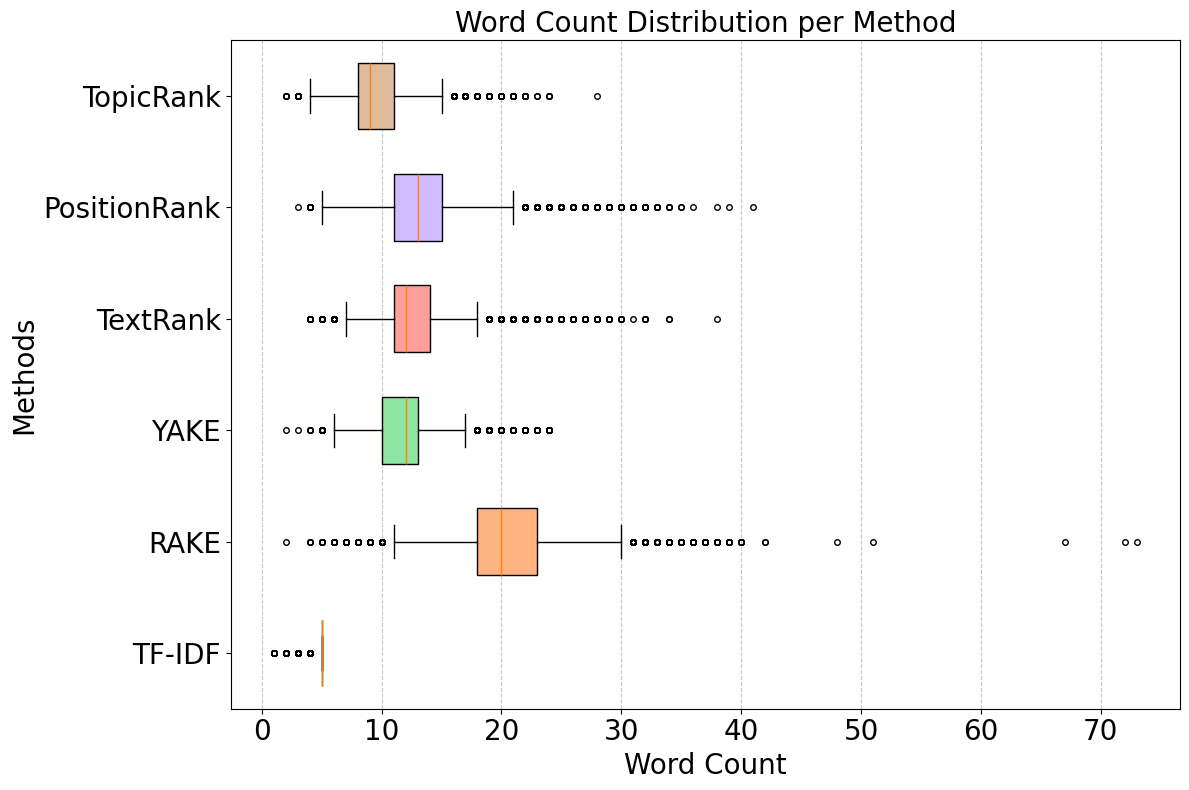

In [39]:
analyze_word_counts([
    'Word_Counts/TFIDF5.txt',
    'Word_Counts/RAKE5.txt',
    'Word_Counts/YAKE5.txt',
    'Word_Counts/TextRank5.txt',
    'Word_Counts/PosRank5.txt',
    'Word_Counts/TopicRank5.txt'
])